In [17]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 08a

## Working with Tensorflow 
- One hidden layer
- ${Swish}$ activation function
- Adam
- Multi-class output
- FIFA dataset

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [18]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_torch_hist

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [20]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location of the images
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
# np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
# tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 30 # number of epochs
ALPHA = 0.001 # learning rate

BATCH_SIZE = 32

TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [21]:
# # Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [22]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read FIFA 2019 data set

In [23]:
test_df = pd.read_csv(r'C:\Users\Administrator.DAI-PC2\Desktop\PGDAI\5. DNN\Repository\input\fashion_mnist\fashion-mnist_test.csv')
train_df = pd.read_csv(r'C:\Users\Administrator.DAI-PC2\Desktop\PGDAI\5. DNN\Repository\input\fashion_mnist\fashion-mnist_train.csv')

In [24]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
class_labels={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot',
}

In [26]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [27]:
class FashionDS(Dataset):

    def __init__(self,
                 dataframe:pd.DataFrame,
                 device:str=device,
                 ):
        
        self.df=dataframe
        self.device=device

        self.labels=self.df['label'].to_numpy()
        X=self.df.drop('label',axis=1).to_numpy()
        
        self.features=X/255.
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        features=self.features[index]
        label=self.labels[index]
        
        features=torch.tensor(features,
                              dtype=torch.float32,
                              device=self.device)

        label=torch.tensor(label,
                              dtype=torch.int64,
                              device=self.device)

        return features,label           



In [28]:

train_ds=FashionDS(train_df)
test_ds=FashionDS(test_df)


In [29]:
train_loader=DataLoader(train_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )


test_loader=DataLoader(test_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )

In [30]:
images, targets= next(iter(train_loader))
images=images.cpu().numpy()
targets=targets.cpu().numpy()
targets

array([0, 3, 6, 8, 2, 3, 7, 8, 5, 0, 1, 5, 3, 0, 4, 7, 5, 0, 6, 8, 5, 7,
       6, 5, 9, 8, 8, 4, 9, 5, 5, 2], dtype=int64)

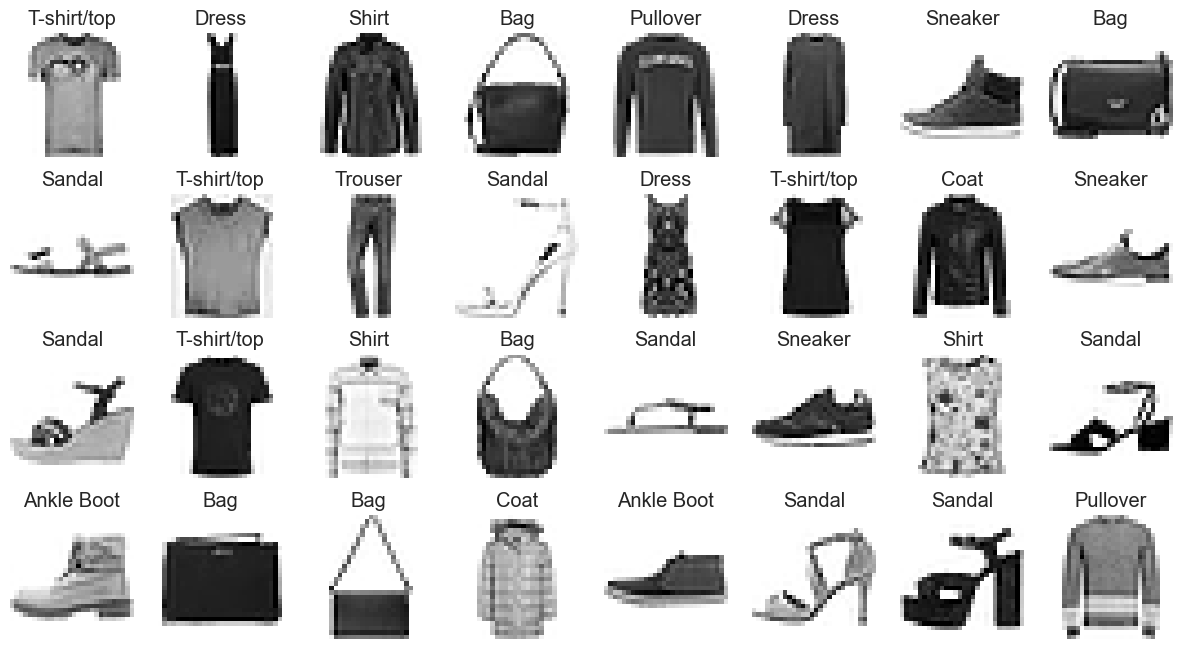

In [31]:
plt.figure(figsize=(15,8))
for i in range(BATCH_SIZE):
    plt.subplot(4,8,i+1)
    plt.imshow(images[i].reshape(28,28),cmap=plt.cm.binary)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_labels[targets[i]])

In [32]:
input_shape=train_df.shape[1]-1
input_shape

784

In [34]:
class Model(nn.Module):
    def __init__(self,input_dim):
        super(Model,self).__init__()
        self.layer1=nn.Linear(input_dim,120)
        self.activ1=nn.ReLU()
        self.layer2=nn.Linear(120,32)
        self.activ2=nn.ReLU()
        self.layer3=nn.Linear(32,10)
        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self,x):
        x=self.layer1(x) #layer 1 aggregation
        x=self.activ1(x) #layer 1 activation
        x=self.layer2(x) #layer 1 aggregation
        x=self.activ2(x)
        x=self.layer3(x) #layer 1 aggregation
        #x=self.activ1(x)
        #x=F.softmax(self.layer2(x),dim=1) #layer 2 activation
        return self.softmax(x)
    
net = Model(input_dim=input_shape).to(device)
print(net)

Model(
  (layer1): Linear(in_features=784, out_features=120, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=120, out_features=32, bias=True)
  (activ2): ReLU()
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [35]:
train_loader=DataLoader(train_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )


test_loader=DataLoader(test_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )

In [36]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:0.5413, test:0.4348 | Acc - train:0.8095, test:0.8411
At epoch 5 | Loss - train:0.2941, test:0.3267 | Acc - train:0.8913, test:0.8781
At epoch 10 | Loss - train:0.2435, test:0.3169 | Acc - train:0.9089, test:0.8852
At epoch 15 | Loss - train:0.2081, test:0.3329 | Acc - train:0.9214, test:0.8886
At epoch 20 | Loss - train:0.1861, test:0.3146 | Acc - train:0.9303, test:0.8990
At epoch 25 | Loss - train:0.1627, test:0.3527 | Acc - train:0.9380, test:0.8927


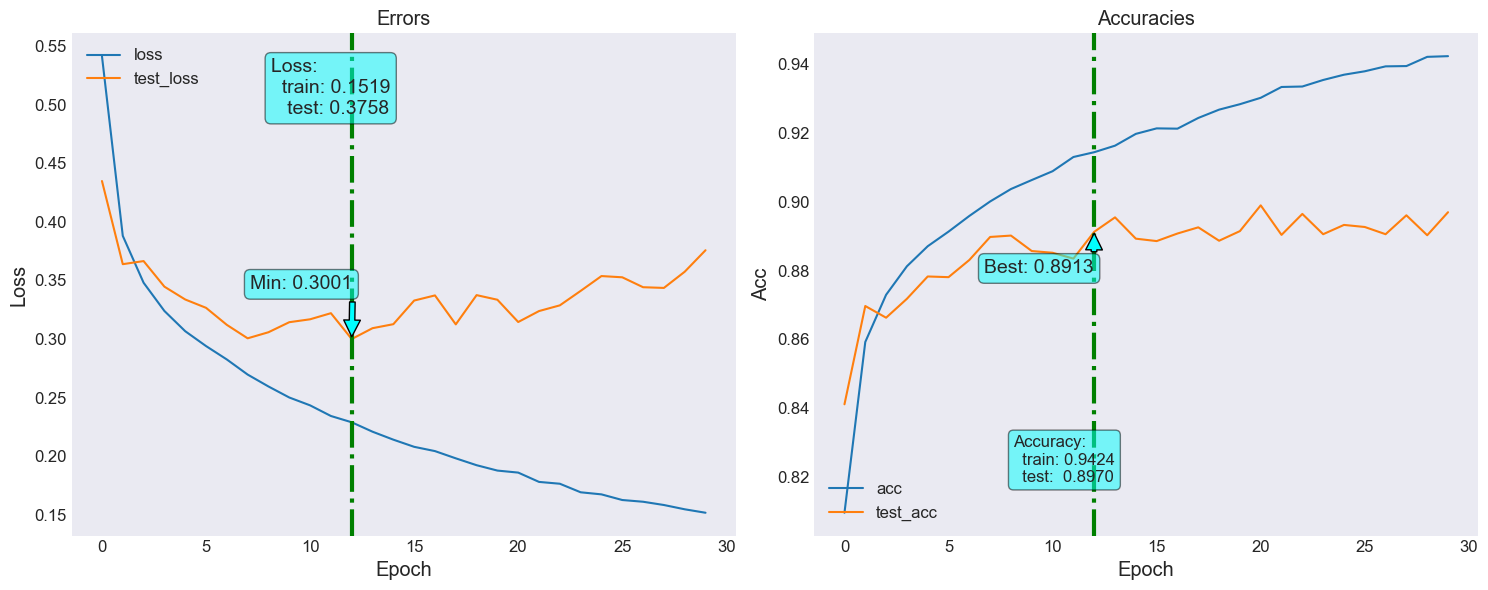

In [37]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

fn_plot_torch_hist(loss_df)

In [38]:
y_train=[]
y_pred=[]
for i ,data in enumerate(train_loader):
    inputs,labels=data
    outputs=net(inputs)
    preds=torch.argmax(outputs,dim=1)
    y_train.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

In [39]:
print(classification_report(y_train, y_pred ))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      6000
           1       0.99      1.00      1.00      6000
           2       0.87      0.93      0.90      6000
           3       0.95      0.97      0.96      6000
           4       0.92      0.86      0.89      6000
           5       1.00      1.00      1.00      6000
           6       0.86      0.87      0.87      6000
           7       0.99      0.99      0.99      6000
           8       1.00      1.00      1.00      6000
           9       0.99      0.99      0.99      6000

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000



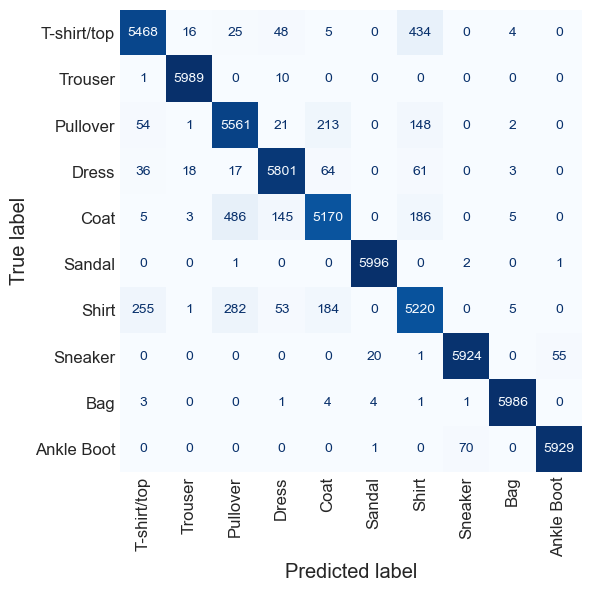

In [40]:
fn_plot_confusion_matrix(y_train, y_pred, labels=class_labels)